In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches
from scarches.models import TRANVAE
from scarches.dataset import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [4]:
label_ratio = 1

In [5]:
condition_key = 'condition'
cell_type_key = 'final_annotation'
target_conditions = ['Sun', 'Freytag']


tranvae_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [6]:
adata_all = sc.read(os.path.expanduser(f'~/Documents/benchmarking_datasets/Immune_ALL_human_wo_villani_rqr_normalized_hvg.h5ad'))
adata = adata_all.raw.to_adata()
adata = remove_sparsity(adata)
source_adata = adata[~adata.obs.study.isin(target_conditions)].copy()
target_adata = adata[adata.obs.study.isin(target_conditions)].copy()
source_conditions = source_adata.obs[condition_key].unique().tolist()
source_labels = source_adata.obs[cell_type_key].unique().tolist()

In [7]:
source_adata

AnnData object with n_obs × n_vars = 12186 × 4000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'condition'

In [8]:
print(len(source_labels))
source_labels

14


['CD16+ Monocytes',
 'HSPCs',
 'CD8+ T cells',
 'Erythrocytes',
 'CD10+ B cells',
 'Plasmacytoid dendritic cells',
 'Monocyte progenitors',
 'CD20+ B cells',
 'Monocyte-derived dendritic cells',
 'Plasma cells',
 'Erythroid progenitors',
 'Megakaryocyte progenitors',
 'NK cells',
 'CD14+ Monocytes']

In [9]:
target_adata

AnnData object with n_obs × n_vars = 8336 × 4000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'condition'

In [10]:
target_adata.obs[cell_type_key].unique().tolist()

['CD8+ T cells',
 'NKT cells',
 'NK cells',
 'CD20+ B cells',
 'Megakaryocyte progenitors',
 'Plasmacytoid dendritic cells',
 'CD16+ Monocytes',
 'CD4+ T cells',
 'Monocyte-derived dendritic cells']

In [11]:
idx = np.arange(len(target_adata))
np.random.shuffle(idx)
n_labeled = int(label_ratio*len(target_adata))
labeled_ind = idx[:n_labeled]

In [12]:
print(target_adata.obs[condition_key][labeled_ind].unique().tolist())
print(target_adata.obs[condition_key][~labeled_ind].unique().tolist())
print(target_adata.obs[cell_type_key][labeled_ind].unique().tolist())
print(target_adata.obs[cell_type_key][~labeled_ind].unique().tolist())

['Sun_sample4_TC', 'Sun_sample1_CS', 'Freytag', 'Sun_sample3_TB', 'Sun_sample2_KC']
['Freytag', 'Sun_sample3_TB', 'Sun_sample4_TC', 'Sun_sample1_CS', 'Sun_sample2_KC']
['NK cells', 'CD4+ T cells', 'CD20+ B cells', 'CD16+ Monocytes', 'CD8+ T cells', 'NKT cells', 'Monocyte-derived dendritic cells', 'Plasmacytoid dendritic cells', 'Megakaryocyte progenitors']
['NKT cells', 'CD4+ T cells', 'NK cells', 'CD20+ B cells', 'CD8+ T cells', 'CD16+ Monocytes', 'Megakaryocyte progenitors', 'Monocyte-derived dendritic cells', 'Plasmacytoid dendritic cells']


In [13]:
load_path = os.path.expanduser(f'~/Documents/aaa_dev_mars/pbmc_testing/')
tranvae = scarches.models.TRANVAE.load_query_data(
    adata=target_adata,
    reference_model = f'{load_path}reference_model/',
    labeled_indices=labeled_ind,
    n_clusters=9,
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 9
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 9
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4000 



In [14]:
tranvae.model.condition_encoder

{'Oetjen_A': 0,
 'Oetjen_P': 1,
 'Oetjen_U': 2,
 '10X': 3,
 'Freytag': 4,
 'Sun_sample1_CS': 5,
 'Sun_sample2_KC': 6,
 'Sun_sample3_TB': 7,
 'Sun_sample4_TC': 8}

In [15]:
tranvae.model.cell_type_encoder

{'CD16+ Monocytes': 0,
 'HSPCs': 1,
 'CD8+ T cells': 2,
 'Erythrocytes': 3,
 'CD10+ B cells': 4,
 'Plasmacytoid dendritic cells': 5,
 'Monocyte progenitors': 6,
 'CD20+ B cells': 7,
 'Monocyte-derived dendritic cells': 8,
 'Plasma cells': 9,
 'Erythroid progenitors': 10,
 'Megakaryocyte progenitors': 11,
 'NK cells': 12,
 'CD14+ Monocytes': 13,
 'NKT cells': 14,
 'CD4+ T cells': 15}

In [16]:
tranvae.model.landmarks_labeled

array([[ 1.29, -0.45, -0.04,  0.26, -0.53, -0.17, -1.67,  0.31, -1.21,
        -0.92],
       [ 0.8 , -0.49, -1.33,  0.58,  0.41,  0.24, -1.36,  0.91,  0.49,
        -0.41],
       [ 0.29, -0.15,  0.17,  1.84,  0.01,  0.09, -0.61,  0.23, -0.33,
        -0.65],
       [ 0.  ,  0.13, -1.2 ,  0.36, -0.92,  0.24, -0.73, -0.33,  0.05,
        -0.71],
       [ 0.79, -0.53, -1.34,  0.51,  0.42,  0.29, -1.33,  0.89,  0.58,
        -0.4 ],
       [ 1.18, -0.16, -0.56,  0.11, -0.4 ,  0.67,  0.48,  0.37, -0.09,
        -0.58],
       [ 0.82, -0.5 , -1.34,  0.54,  0.38,  0.22, -1.43,  0.86,  0.5 ,
        -0.4 ],
       [ 0.62, -0.22,  1.09, -0.63, -0.03,  0.41, -0.2 ,  0.29, -0.8 ,
        -0.38],
       [ 1.29, -0.38, -0.07,  0.19, -0.47, -0.1 , -1.69,  0.35, -1.25,
        -0.92],
       [ 1.18, -0.2 , -0.48,  0.12, -0.47,  0.62,  0.5 ,  0.31, -0.05,
        -0.57],
       [-0.03,  0.15, -1.21,  0.33, -0.9 ,  0.29, -0.75, -0.29,  0.04,
        -0.71],
       [ 0.74, -0.43, -1.38,  0.54,  0.35, 

In [17]:
tranvae.model.landmarks_unlabeled

array([[-0.29, -0.26,  0.39, -0.46,  0.09,  0.77, -1.8 ,  0.28,  0.2 ,
        -0.67],
       [ 0.8 , -0.49, -1.35,  0.54,  0.4 ,  0.24, -1.38,  0.89,  0.52,
        -0.41],
       [ 0.17, -0.45, -2.3 ,  1.02, -0.03,  0.05, -0.09,  0.37, -1.07,
        -0.73],
       [ 1.3 , -0.37, -0.05,  0.23, -0.51, -0.16, -1.7 ,  0.33, -1.23,
        -0.92],
       [ 1.2 , -0.14, -0.53,  0.16, -0.46,  0.62,  0.54,  0.36, -0.05,
        -0.59],
       [-0.74, -0.1 ,  0.38,  0.11, -0.24, -0.57, -0.12,  0.57, -0.47,
        -0.73],
       [ 0.29, -0.15,  0.17,  1.84,  0.01,  0.09, -0.61,  0.23, -0.33,
        -0.65],
       [-0.89, -0.02, -0.92,  0.52,  0.59,  0.13, -1.64,  0.2 , -1.2 ,
        -0.68],
       [-0.16, -0.57, -1.05, -0.96,  0.12,  0.61, -0.54,  0.85, -1.87,
        -0.42],
       [ 0.62, -0.22,  1.09, -0.63, -0.03,  0.4 , -0.2 ,  0.29, -0.8 ,
        -0.38],
       [-0.01,  0.13, -1.21,  0.35, -0.92,  0.26, -0.73, -0.32,  0.04,
        -0.71],
       [-0.5 , -0.24, -0.88, -0.08,  0.94, 

In [18]:
tranvae.model.new_landmarks

[14, 15]

In [19]:
surgery_epochs=500
tranvae.train(
    n_epochs=surgery_epochs,
    early_stopping_kwargs=early_stopping_kwargs,
    eta=1000,
    tau=0,
    weight_decay=0
)

 |███████-------------| 37.2%  - epoch_loss: 2100.87 - epoch_trvae_loss: 2054.64 - epoch_classifier_loss:   46.23 - epoch_unlabeled_loss:    0.00 - epoch_labeled_loss:    0.05 - val_loss: 2073.10 - val_trvae_loss: 2009.53 - val_classifier_loss:   63.58 - val_unlabeled_loss:    0.00 - val_labeled_loss:    0.06
ADJUSTED LR
 |███████-------------| 38.6%  - epoch_loss: 2081.44 - epoch_trvae_loss: 2033.04 - epoch_classifier_loss:   48.39 - epoch_unlabeled_loss:    0.00 - epoch_labeled_loss:    0.05 - val_loss: 2091.54 - val_trvae_loss: 2028.65 - val_classifier_loss:   62.90 - val_unlabeled_loss:    0.00 - val_labeled_loss:    0.06
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 171


In [20]:
adata_latent = sc.AnnData(tranvae.get_latent())
adata_latent.obs['celltype'] = target_adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = target_adata.obs[condition_key].tolist()
adata_latent.obs['predictions'] = tranvae.classify()

... storing 'celltype' as categorical
... storing 'batch' as categorical
... storing 'predictions' as categorical


[<AxesSubplot:title={'center':'batch'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>]

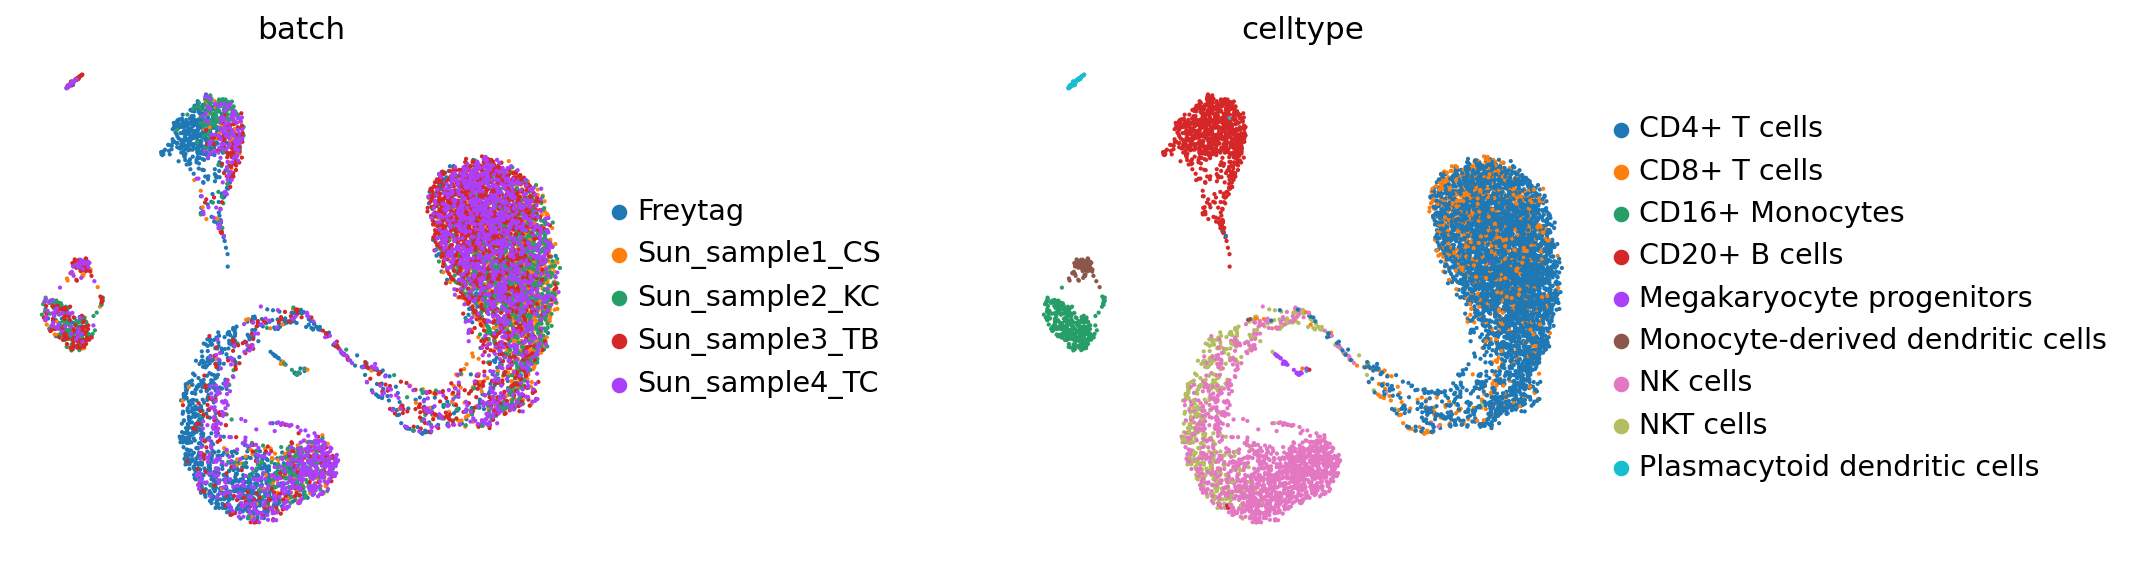

In [21]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'celltype'],
           frameon=False,
           wspace=0.6,
           show=False
           )

In [22]:
print("Acc: {}".format(np.mean(adata_latent.obs.predictions.tolist() == adata_latent.obs.celltype)))

Acc: 0.7362044145873321


In [23]:
full_latent = sc.AnnData(tranvae.get_latent(adata.X, adata.obs[condition_key]))
full_latent.obs['celltype'] = adata.obs[cell_type_key].tolist()
full_latent.obs['batch'] = adata.obs[condition_key].tolist()
full_latent.obs['predictions'] = tranvae.classify(adata.X, adata.obs[condition_key])

... storing 'celltype' as categorical
... storing 'batch' as categorical
... storing 'predictions' as categorical


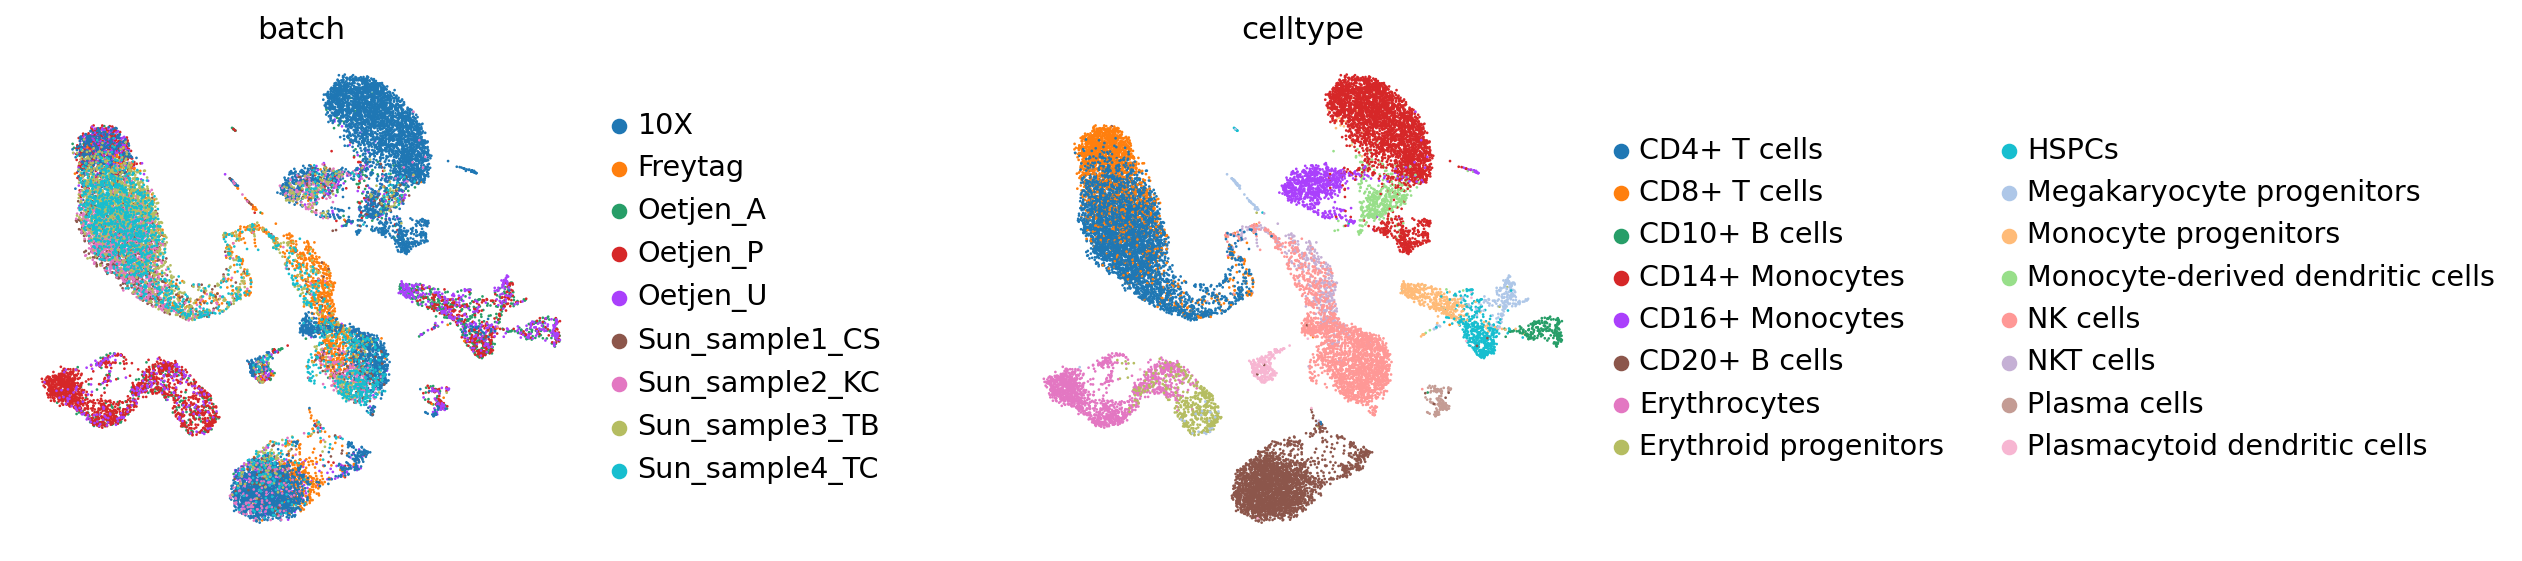

In [24]:
sc.pp.neighbors(full_latent, n_neighbors=8)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
sc.pl.umap(full_latent,
           color=['batch', 'celltype'],
           frameon=False,
           wspace=0.6,
           )

In [25]:
print("Acc: {}".format(np.mean(full_latent.obs.predictions.tolist() == full_latent.obs.celltype)))

Acc: 0.8634636000389826


In [26]:
print(tranvae.landmarks_labeled_.shape)
print(tranvae.landmarks_unlabeled_.shape)

(16, 10)
(14, 10)


In [27]:
tranvae.model.landmarks_labeled

tensor([[ 1.291, -0.454, -0.037,  0.257, -0.529, -0.165, -1.673,  0.311, -1.212,
         -0.922],
        [ 0.803, -0.489, -1.331,  0.579,  0.411,  0.244, -1.363,  0.906,  0.493,
         -0.412],
        [ 0.292, -0.147,  0.174,  1.837,  0.015,  0.094, -0.608,  0.233, -0.335,
         -0.654],
        [ 0.003,  0.129, -1.198,  0.359, -0.921,  0.240, -0.734, -0.333,  0.046,
         -0.707],
        [ 0.786, -0.532, -1.343,  0.514,  0.417,  0.291, -1.334,  0.893,  0.577,
         -0.397],
        [ 1.181, -0.156, -0.556,  0.112, -0.400,  0.667,  0.483,  0.375, -0.089,
         -0.579],
        [ 0.817, -0.498, -1.337,  0.538,  0.384,  0.216, -1.428,  0.861,  0.505,
         -0.403],
        [ 0.622, -0.219,  1.090, -0.628, -0.032,  0.405, -0.200,  0.290, -0.801,
         -0.377],
        [ 1.293, -0.379, -0.068,  0.191, -0.471, -0.096, -1.686,  0.347, -1.252,
         -0.922],
        [ 1.179, -0.198, -0.481,  0.117, -0.469,  0.615,  0.501,  0.312, -0.046,
         -0.571],
        [-

In [28]:
tranvae.model.landmarks_unlabeled

tensor([[-0.294, -0.260,  0.386, -0.461,  0.091,  0.767, -1.801,  0.276,  0.197,
         -0.666],
        [ 0.796, -0.489, -1.352,  0.544,  0.401,  0.235, -1.376,  0.895,  0.519,
         -0.406],
        [ 0.167, -0.447, -2.301,  1.015, -0.027,  0.055, -0.090,  0.365, -1.072,
         -0.735],
        [ 1.300, -0.371, -0.051,  0.227, -0.506, -0.156, -1.698,  0.333, -1.226,
         -0.922],
        [ 1.200, -0.143, -0.531,  0.159, -0.459,  0.618,  0.536,  0.358, -0.049,
         -0.590],
        [-0.745, -0.100,  0.384,  0.109, -0.243, -0.567, -0.117,  0.565, -0.471,
         -0.730],
        [ 0.294, -0.146,  0.172,  1.837,  0.013,  0.094, -0.606,  0.232, -0.333,
         -0.652],
        [-0.886, -0.021, -0.917,  0.522,  0.593,  0.126, -1.639,  0.196, -1.195,
         -0.680],
        [-0.156, -0.568, -1.047, -0.957,  0.119,  0.611, -0.544,  0.851, -1.875,
         -0.415],
        [ 0.621, -0.221,  1.094, -0.634, -0.033,  0.405, -0.199,  0.287, -0.801,
         -0.376],
        [-